## TensorFlow 2.0 설치
[런타임] -> [런타임 유형변경]에서 하드웨어 가속기를 꼭 GPU로 설정!

In [0]:
!pip install tensorflow-gpu==2.0.0

## Importing Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


## Enable Eager Mode

In [0]:
if tf.__version__ < '2.0.0':
    tf.enable_eager_execution()

## Hyper Parameters

In [0]:
learning_rate = 0.001
training_epochs = 20
batch_size = 100
n_class = 10

## MNIST/Fashion MNIST Data

In [0]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

In [0]:
type(train_images), type(train_labels)

(numpy.ndarray, numpy.ndarray)

In [0]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [0]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [0]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(train_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [0]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(test_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

In [0]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]

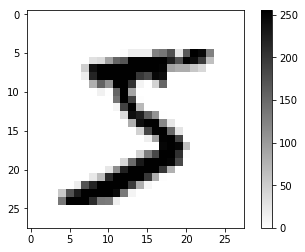

In [0]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()

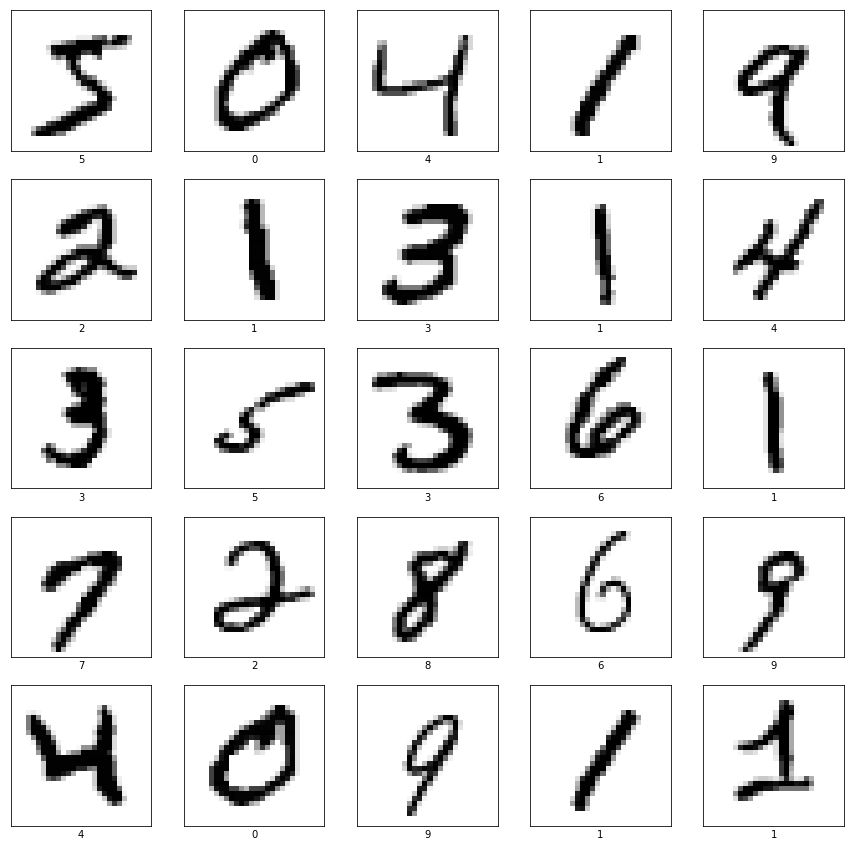

In [0]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [0]:
## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

## one-hot encoding
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)

In [0]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Linear Regression Model

In [0]:
def create_lr_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [0]:
lr_model = create_lr_model()
lr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Loss & Optimizer

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [0]:
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.CategoricalAccuracy()

test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.CategoricalAccuracy()

## Train & Test function

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = lr_model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, lr_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, lr_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  predictions = lr_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

## Training

In [0]:
for epoch in range(training_epochs):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch: {}, loss: {:.4f}, accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result(),
                         test_loss.result(),
                         test_accuracy.result()))

Epoch: 1, loss: 0.6279, accuracy: 0.8411, val_loss: 0.3628, val_accuracy: 0.9041
Epoch: 2, loss: 0.4870, accuracy: 0.8735, val_loss: 0.3361, val_accuracy: 0.9090
Epoch: 3, loss: 0.4278, accuracy: 0.8871, val_loss: 0.3203, val_accuracy: 0.9124
Epoch: 4, loss: 0.3939, accuracy: 0.8949, val_loss: 0.3100, val_accuracy: 0.9151
Epoch: 5, loss: 0.3715, accuracy: 0.9002, val_loss: 0.3031, val_accuracy: 0.9165
Epoch: 6, loss: 0.3553, accuracy: 0.9040, val_loss: 0.2980, val_accuracy: 0.9177
Epoch: 7, loss: 0.3431, accuracy: 0.9070, val_loss: 0.2939, val_accuracy: 0.9186
Epoch: 8, loss: 0.3334, accuracy: 0.9094, val_loss: 0.2908, val_accuracy: 0.9194
Epoch: 9, loss: 0.3254, accuracy: 0.9114, val_loss: 0.2882, val_accuracy: 0.9201
Epoch: 10, loss: 0.3188, accuracy: 0.9131, val_loss: 0.2857, val_accuracy: 0.9208
Epoch: 11, loss: 0.3132, accuracy: 0.9145, val_loss: 0.2839, val_accuracy: 0.9212
Epoch: 12, loss: 0.3083, accuracy: 0.9157, val_loss: 0.2823, val_accuracy: 0.9216
Epoch: 13, loss: 0.3041, 

# Using Keras

In [0]:
## dataset에 repeat()추가
train_dataset = train_dataset.repeat()
test_dataset = test_dataset.repeat()

In [0]:
## 새로운 model 만들기
lr_model_k = create_lr_model()

## Model Compile(Optimizer & Loss Function)

In [0]:
lr_model_k.compile(optimizers=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

## Training

In [0]:
steps_per_epoch = n_train//batch_size
validation_steps = n_test//batch_size
print(steps_per_epoch, validation_steps) 

600 100


In [0]:
history = lr_model_k.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 4s 6ms/step - loss: 0.5630 - accuracy: 0.8568 - val_loss: 0.3318 - val_accuracy: 0.9087
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.3223 - accuracy: 0.9100 - val_loss: 0.2939 - val_accuracy: 0.9195
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2973 - accuracy: 0.9172 - val_loss: 0.2819 - val_accuracy: 0.9224
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2855 - accuracy: 0.9204 - val_loss: 0.2763 - val_accuracy: 0.9239
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2780 - accuracy: 0.9231 - val_loss: 0.2734 - val_accuracy: 0.9251
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2731 - accuracy: 0.9246 - val_loss: 0.2705 - val_accuracy: 0.9256
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2694 - accuracy: 0.9260 - va

## Training 결과 확인

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

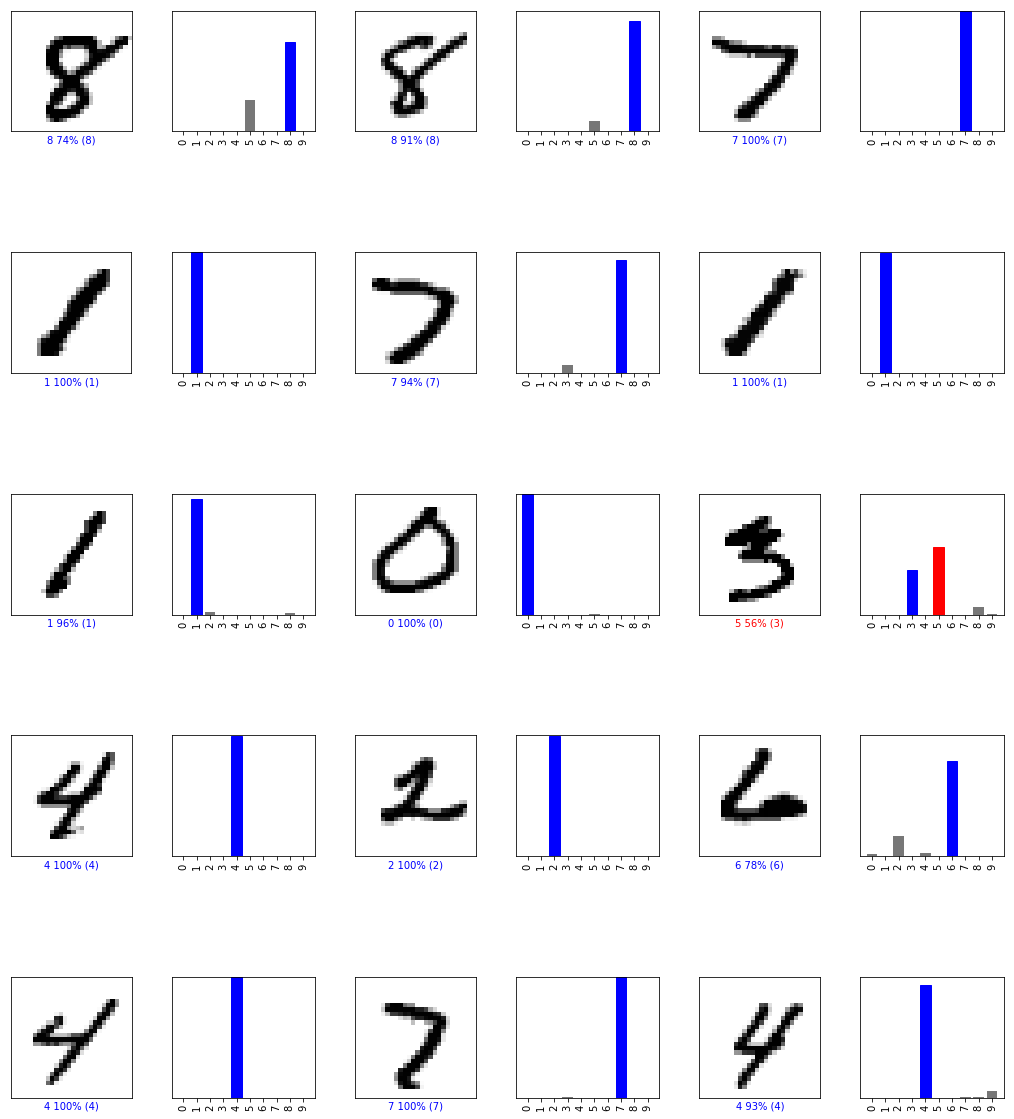

In [0]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = lr_model_k(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

## Multi-Layer Perceptron Model - 3 layers

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

## one-hot encoding
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)

In [0]:
## dataset 구성 - repeat() 다시 빼기 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [0]:
def create_mlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [0]:
mlp_model = create_mlp_model()
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [0]:
## reset metrics
train_loss.reset_states()
train_accuracy.reset_states()
test_loss.reset_states()
test_accuracy.reset_states()

In [0]:
## train function
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = mlp_model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, mlp_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, mlp_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
## test function
@tf.function
def test_step(images, labels):
  predictions = mlp_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
## Training
for epoch in range(training_epochs):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch: {}, loss: {:.4f}, accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result(),
                         test_loss.result(),
                         test_accuracy.result()))

Epoch: 1, loss: 0.1847, accuracy: 0.9436, val_loss: 0.0982, val_accuracy: 0.9690
Epoch: 2, loss: 0.1279, accuracy: 0.9606, val_loss: 0.0872, val_accuracy: 0.9725
Epoch: 3, loss: 0.1009, accuracy: 0.9689, val_loss: 0.0806, val_accuracy: 0.9746
Epoch: 4, loss: 0.0838, accuracy: 0.9741, val_loss: 0.0770, val_accuracy: 0.9762
Epoch: 5, loss: 0.0718, accuracy: 0.9779, val_loss: 0.0751, val_accuracy: 0.9770
Epoch: 6, loss: 0.0629, accuracy: 0.9806, val_loss: 0.0750, val_accuracy: 0.9774
Epoch: 7, loss: 0.0559, accuracy: 0.9828, val_loss: 0.0745, val_accuracy: 0.9776
Epoch: 8, loss: 0.0505, accuracy: 0.9844, val_loss: 0.0729, val_accuracy: 0.9782
Epoch: 9, loss: 0.0460, accuracy: 0.9858, val_loss: 0.0727, val_accuracy: 0.9785
Epoch: 10, loss: 0.0421, accuracy: 0.9870, val_loss: 0.0729, val_accuracy: 0.9787
Epoch: 11, loss: 0.0392, accuracy: 0.9879, val_loss: 0.0746, val_accuracy: 0.9787
Epoch: 12, loss: 0.0366, accuracy: 0.9887, val_loss: 0.0758, val_accuracy: 0.9788
Epoch: 13, loss: 0.0345, 

## Using Keras

In [0]:
## dataset에 repeat()추가
train_dataset = train_dataset.repeat()
test_dataset = test_dataset.repeat()

In [0]:
## 새로운 model 만들기
mlp_model_k = create_mlp_model()

In [0]:
## model compile
mlp_model_k.compile(optimizers=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
## training
history = mlp_model_k.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 4s 7ms/step - loss: 0.2446 - accuracy: 0.9281 - val_loss: 0.1135 - val_accuracy: 0.9643
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0954 - accuracy: 0.9707 - val_loss: 0.0962 - val_accuracy: 0.9696
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0668 - accuracy: 0.9799 - val_loss: 0.0763 - val_accuracy: 0.9766
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0478 - accuracy: 0.9855 - val_loss: 0.0728 - val_accuracy: 0.9781
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0370 - accuracy: 0.9889 - val_loss: 0.0744 - val_accuracy: 0.9790
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0291 - accuracy: 0.9909 - val_loss: 0.0796 - val_accuracy: 0.9778
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0235 - accuracy: 0.9924 - va

## Multi-Layer Perceptron Model - 5 layers

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

## one-hot encoding
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)

In [0]:
## dataset 구성 - repeat() 다시 빼기 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [0]:
def create_dmlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))    
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [0]:
dmlp_model = create_dmlp_model()
dmlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
## dataset 구성 - repeat() 다시 빼기 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [0]:
## reset metrics
train_loss.reset_states()
train_accuracy.reset_states()
test_loss.reset_states()
test_accuracy.reset_states()

In [0]:
## train function
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = dmlp_model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, dmlp_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, dmlp_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
## test function
@tf.function
def test_step(images, labels):
  predictions = dmlp_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
## Training
for epoch in range(training_epochs):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch: {}, loss: {:.4f}, accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result(),
                         test_loss.result(),
                         test_accuracy.result()))

Epoch: 1, loss: 0.2099, accuracy: 0.9347, val_loss: 0.1089, val_accuracy: 0.9665
Epoch: 2, loss: 0.1445, accuracy: 0.9556, val_loss: 0.0964, val_accuracy: 0.9712
Epoch: 3, loss: 0.1142, accuracy: 0.9647, val_loss: 0.0939, val_accuracy: 0.9719
Epoch: 4, loss: 0.0959, accuracy: 0.9703, val_loss: 0.0896, val_accuracy: 0.9733
Epoch: 5, loss: 0.0827, accuracy: 0.9744, val_loss: 0.0872, val_accuracy: 0.9747
Epoch: 6, loss: 0.0733, accuracy: 0.9772, val_loss: 0.0865, val_accuracy: 0.9755
Epoch: 7, loss: 0.0661, accuracy: 0.9794, val_loss: 0.0890, val_accuracy: 0.9752
Epoch: 8, loss: 0.0602, accuracy: 0.9812, val_loss: 0.0871, val_accuracy: 0.9760
Epoch: 9, loss: 0.0553, accuracy: 0.9828, val_loss: 0.0883, val_accuracy: 0.9761
Epoch: 10, loss: 0.0514, accuracy: 0.9840, val_loss: 0.0894, val_accuracy: 0.9763
Epoch: 11, loss: 0.0480, accuracy: 0.9850, val_loss: 0.0901, val_accuracy: 0.9766
Epoch: 12, loss: 0.0450, accuracy: 0.9860, val_loss: 0.0914, val_accuracy: 0.9769
Epoch: 13, loss: 0.0425, 

## Using Keras

In [0]:
## dataset에 repeat()추가
train_dataset = train_dataset.repeat()
test_dataset = test_dataset.repeat()

In [0]:
## 새로운 model 만들기
dmlp_model_k = create_dmlp_model()

In [0]:
## model compile
dmlp_model_k.compile(optimizers=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
## training
history = dmlp_model_k.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 5s 8ms/step - loss: 0.2569 - accuracy: 0.9201 - val_loss: 0.1455 - val_accuracy: 0.9538
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1010 - accuracy: 0.9701 - val_loss: 0.0883 - val_accuracy: 0.9728
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0699 - accuracy: 0.9790 - val_loss: 0.1165 - val_accuracy: 0.9686
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0534 - accuracy: 0.9848 - val_loss: 0.1058 - val_accuracy: 0.9704
Epoch 5/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0428 - accuracy: 0.9873 - val_loss: 0.0973 - val_accuracy: 0.9758
Epoch 6/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0346 - accuracy: 0.9897 - val_loss: 0.0953 - val_accuracy: 0.9786
Epoch 7/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0303 - accuracy: 0.9912 - va

## Drop-out

In [0]:
drop_rate = 0.3

def create_do_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [0]:
do_model = create_do_model()
do_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [0]:
do_model.compile(optimizers=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
history = do_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 5s 8ms/step - loss: 0.4318 - accuracy: 0.8673 - val_loss: 0.1585 - val_accuracy: 0.9527
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1923 - accuracy: 0.9485 - val_loss: 0.1113 - val_accuracy: 0.9679
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1506 - accuracy: 0.9603 - val_loss: 0.1077 - val_accuracy: 0.9732
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1303 - accuracy: 0.9661 - val_loss: 0.0889 - val_accuracy: 0.9764
Epoch 5/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1197 - accuracy: 0.9694 - val_loss: 0.0966 - val_accuracy: 0.9772
Epoch 6/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1128 - accuracy: 0.9718 - val_loss: 0.0921 - val_accuracy: 0.9790
Epoch 7/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1073 - accuracy: 0.9741 - va

## Weight Decay (L2 Regulrarization)

In [0]:
reg_weight = 0.0002

def create_l2r_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))    
    model.add(keras.layers.Dense(10, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    return model

In [0]:
l2r_model = create_l2r_model()
l2r_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
l2r_model.compile(optimizers=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
history = l2r_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 5s 8ms/step - loss: 0.4073 - accuracy: 0.9191 - val_loss: 0.2418 - val_accuracy: 0.9658
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: 0.2249 - accuracy: 0.9678 - val_loss: 0.2006 - val_accuracy: 0.9706
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1821 - accuracy: 0.9739 - val_loss: 0.1717 - val_accuracy: 0.9761
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1571 - accuracy: 0.9779 - val_loss: 0.1504 - val_accuracy: 0.9778
Epoch 5/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1377 - accuracy: 0.9807 - val_loss: 0.2007 - val_accuracy: 0.9623
Epoch 6/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1279 - accuracy: 0.9819 - val_loss: 0.1420 - val_accuracy: 0.9767
Epoch 7/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1185 - accuracy: 0.9834 - va

## Batch Normalization

In [0]:
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Softmax())
    return model

In [0]:
bn_model = create_bn_model()
bn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)              

In [0]:
bn_model.compile(optimizers=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
history = bn_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 10s 17ms/step - loss: 0.3543 - accuracy: 0.9416 - val_loss: 0.1678 - val_accuracy: 0.9709
Epoch 2/20
600/600 [==============================] - 8s 13ms/step - loss: 0.1378 - accuracy: 0.9722 - val_loss: 0.0984 - val_accuracy: 0.9757
Epoch 3/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0839 - accuracy: 0.9803 - val_loss: 0.0748 - val_accuracy: 0.9809
Epoch 4/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0616 - accuracy: 0.9847 - val_loss: 0.0824 - val_accuracy: 0.9766
Epoch 5/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0484 - accuracy: 0.9873 - val_loss: 0.0672 - val_accuracy: 0.9814
Epoch 6/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0383 - accuracy: 0.9895 - val_loss: 0.0616 - val_accuracy: 0.9816
Epoch 7/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0320 - accuracy: 0.9

## Learning Rate Decay

In [0]:
lr_decay_model = create_dmlp_model()
lr_decay_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

In [0]:
lr_decay_model.compile(optimizers=keras.optimizers.Adam(lr_schedule),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
history = lr_decay_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 5s 8ms/step - loss: 0.2629 - accuracy: 0.9204 - val_loss: 0.1310 - val_accuracy: 0.9607
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1001 - accuracy: 0.9700 - val_loss: 0.0881 - val_accuracy: 0.9751
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0682 - accuracy: 0.9795 - val_loss: 0.0930 - val_accuracy: 0.9742
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0536 - accuracy: 0.9835 - val_loss: 0.0867 - val_accuracy: 0.9759
Epoch 5/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0871 - val_accuracy: 0.9776
Epoch 6/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0356 - accuracy: 0.9900 - val_loss: 0.1036 - val_accuracy: 0.9766
Epoch 7/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0310 - accuracy: 0.9907 - va